In [7]:
from uproot_io import Events, View
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

random.seed(0)

print("Running...")


thr_std=0.2

E = Events("CheatedRecoFile_1.root")

view_u = View(E, "u")
view_v = View(E, "v")
view_w = View(E, "w")

u_x = view_u.x
u_z = view_u.z
u_adc = view_u.adc
u_truevtx_z = view_u.true_vtx_z
u_truevtx_x = view_u.true_vtx_x

v_x = view_v.x
v_z = view_v.z
v_adc = view_v.adc
v_truevtx_z = view_v.true_vtx_z
v_truevtx_x = view_v.true_vtx_x

w_x = view_w.x
w_z = view_w.z
w_adc = view_w.adc
w_truevtx_z = view_w.true_vtx_z
w_truevtx_x = view_w.true_vtx_x



Running...


In [9]:
print(len(u_x))

9310


In [10]:
def AoI(plane, event_number, thresholding=True, no_std=thr_std):
    if plane=="u":
        AoI_x = u_x[event_number]
        AoI_z = u_z[event_number]
        AoI_adc = u_adc[event_number]
        AoI_truevtxz = u_truevtx_z[event_number]
        AoI_truevtxx = u_truevtx_x[event_number]
    elif plane=="v":
        AoI_x = v_x[event_number]
        AoI_z = v_z[event_number]
        AoI_adc = v_adc[event_number]
        AoI_truevtxz = v_truevtx_z[event_number]
        AoI_truevtxx = v_truevtx_x[event_number]
    elif plane=="w":
        AoI_x = w_x[event_number]
        AoI_z = w_z[event_number]
        AoI_adc = w_adc[event_number]   
        AoI_truevtxz = w_truevtx_z[event_number]
        AoI_truevtxx = w_truevtx_x[event_number]
    else:
        print("PLane not u,v,w")
        
    if thresholding:
        mean = np.average(AoI_adc)
        std = np.std(AoI_adc)
        AoI_x = AoI_x[(mean-no_std*std<AoI_adc)]
        AoI_z = AoI_z[(mean-no_std*std<AoI_adc)]
        AoI_adc = AoI_adc[(mean-no_std*std<AoI_adc)]
    
    return AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx

In [11]:
def plotter(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)


    
    plt.scatter(AoI_z, AoI_x, c=AoI_adc, cmap="viridis")
    plt.title(str(plane)+" plane")
    plt.xlabel("z")
    plt.ylabel("x")

    return 0


In [12]:
def least_z(plane, event_number, thresholding=True, no_std=thr_std):
    
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    min_z = np.amin(AoI_z)
    ind = np.where(min_z)[0]
    min_x = AoI_x[ind]
    #print("Least z prediction for vertex location: (x-position, z-position, plane)=", min_x, min_z, plane)
    return min_z, min_x

In [13]:
def phi_hist(plane, event_number, thresholding=True, no_std=thr_std, leastz=False, centre_coord=(0,0), no_sectors=12, centre=0, printhist=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    if leastz:
        centre_coord = least_z(plane, event_number, thresholding, no_std)
    
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre))
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    
    if printhist:
        plt.hist(hist_data, hist_bins)
        plt.show()

    return norm_score

In [14]:
def rfunc(r):
    return 1/((r+0.01)**(1/2))



def rphi(plane, event_number, thresholding=True, no_std=thr_std, centre_coord=(0,0), func=rfunc, no_sectors=5, centre=0):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    
    centred_x = AoI_x - centre_coord[1]
    centred_z = AoI_z - centre_coord[0]
    
    cen_r = (centred_x**2 + centred_z**2)**0.5
    #distance from central point to every other point
    

    #make the problem tractable (solvable)
    
    weight = rfunc(cen_r)

    theta = np.arctan2(centred_x, centred_z)
    hist_data, hist_bins = np.histogram(theta, no_sectors, (-np.pi+centre,np.pi+centre), weights=weight)
    
    hist_sqr = hist_data**2
    score = np.sum(hist_sqr)
    norm_score = (score/len(theta)**2)**0.5
    

    return norm_score

In [19]:
def optimise_phi(plane, event_number, thresholding=True, no_std=thr_std, no_sectors=20, centre=0, plot=False):
    AoI_x, AoI_z, AoI_adc, AoI_truevtxz, AoI_truevtxx = AoI(plane, event_number, thresholding, no_std)
    no_points = len(AoI_x)
    score_arr = np.zeros(no_points)
    for i in range(no_points):
        centre_co = (AoI_z[i], AoI_x[i])
        score_arr[i] = rphi(plane, event_number, centre_coord=centre_co)
    
    ind = np.argmax(score_arr)
    zmin, xmin = AoI_z[ind], AoI_x[ind]
    if plot:
        plotter(plane, event_number, thresholding, no_std)
        plt.plot(zmin, xmin, 'ro')
        plt.show()
    return zmin, xmin, score_arr[ind]

In [20]:
def accuracy(plane, function, no_events, thresholding=True, no_std=thr_std, ifrandom=True):
    Zvert = []
    Zvert_true = []
    Xvert = []
    Xvert_true = [] #avoid appends to lists; if you know how long the outputs are going to be, then assign the arrays to
                    #that length beforehand
    if ifrandom:
        for i in tqdm(range(no_events)):   
            j = random.randint(0, len(u_x))
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, j, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, j)[0], function(plane, j)[1]
            Zvert.append(Zvert_place)
            Xvert.append(Xvert_place)
            Zvert_true.append(Zvert_true_place)
            Xvert_true.append(Xvert_true_place)
    else:
        for i in tqdm(range(no_events)):
            AoI_x, AoI_z, AoI_adc, Zvert_true_place, Xvert_true_place = AoI(plane, i, thresholding, no_std)
            Zvert_place, Xvert_place = function(plane, i)[0], function(plane, i)[1]
            Zvert.append(Zvert_place)
            Xvert.append(Xvert_place)
            Zvert_true.append(Zvert_true_place)
            Xvert_true.append(Xvert_true_place)
    
    '''
    print(Zvert_true)
    print(Zvert)
    print(Xvert_true)
    print(Xvert)
    '''
    
    delta_z = np.array(Zvert_true) - np.array(Zvert)
    delta_x = np.array(Xvert_true) - np.array(Xvert)
    delta_r2 = delta_z**2 + delta_x**2

    print(len(delta_r2))
    print(delta_r2)
    
    #data, bins = np.histogram(delta_r2)
    #delta_r2 = delta_r2[delta_r2 < 0.4e6]
    delta_r2 = np.sqrt(delta_r2)
    plt.hist(delta_r2, bins='auto')
    #plt.ylim(0, 400)
    plt.show()

    return delta_r2, np.percentile(delta_r2, 68)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:08<00:00,  4.09it/s]


2000
[ 524.34955 2552.6528   691.475   ...  482.9274    81.76624  643.29333]


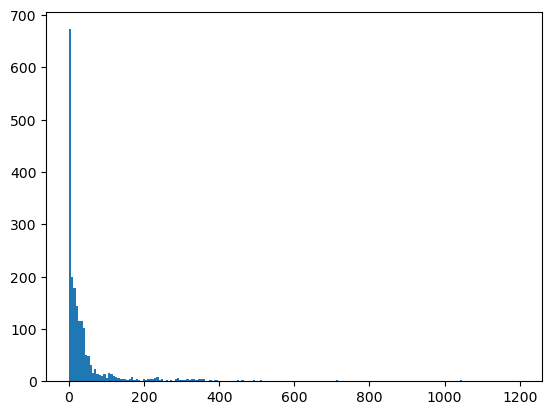

In [21]:
datadata, datadata2 = accuracy("v", optimise_phi, 2000)

In [22]:
print(datadata2)

33.14511444091798
